# Error Cosine Similarity Distribution by Model

This notebook visualizes the distribution of cosine similarity scores for error cases across different models using box plots.


In [217]:
a=1

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [219]:
# Define paths to error_analysis.csv files for each model
project_root = Path.cwd().parent.parent

model_paths = {
    "Qwen2.5-7B-Instruct (Finetuned)": project_root / "output" / "rag_finetuned_llm_text_classification" / "unsloth_Qwen2.5-7B-Instruct-bnb-4bit_25-11-28" / "logs" / "error_analysis.csv",
    "Qwen3-8B-0 (OpenRouter)": project_root / "output" / "rag_llm_text_classification" / "openrouter_qwen_qwen3-8b_25-11-28_0" / "logs" / "error_analysis.csv",
    "Qwen3-8B (OpenRouter)": project_root / "output" / "rag_llm_text_classification" / "openrouter_qwen_qwen3-8b_25-11-28" / "logs" / "error_analysis.csv",
    "Qwen3-Next-80B (OpenRouter)": project_root / "output" / "rag_llm_text_classification" / "openrouter_qwen_qwen3-next-80b-a3b-instruct_25-11-28_5" / "logs" / "error_analysis.csv",
    "Llama-3.3-70B-Instruct (OpenRouter)": project_root / "output" / "rag_llm_text_classification" / "openrouter_llama_llama-3.3-70B-Instruct" / "logs" / "error_analysis.csv"
}

# Load data from all models
all_data = []

for model_name, csv_path in model_paths.items():
    if csv_path.exists():
        df = pd.read_csv(csv_path, encoding='utf-8')
        # Include all entries (including invalid ones with cos_sim == -1)
        df['model'] = model_name
        all_data.append(df)
        invalid_count = len(df[df['cos_sim'] == -1])
        print(f"Loaded {len(df)} entries from {model_name} (invalid: {invalid_count})")
    else:
        print(f"Warning: File not found: {csv_path}")

if not all_data:
    raise ValueError("No data files found!")

# Combine all data
combined_df = pd.concat(all_data, ignore_index=True)

# Map Korean subject names to English
subject_mapping = {
    '과학': 'Science',
    '국어': 'Korean',
    '기술가정': 'Technology & Home Economics',
    '도덕': 'Ethics',
    '사회': 'Social Studies',
    '사회문화': 'Social & Cultural Studies',
    '수학': 'Mathematics',
    '영어': 'English',
    '정보': 'Information'
}

# Apply mapping to subject column
if 'subject' in combined_df.columns:
    combined_df['subject'] = combined_df['subject'].map(subject_mapping).fillna(combined_df['subject'])

# Create a filtered dataframe for visualization (excluding invalid entries)
combined_df_valid = combined_df[combined_df['cos_sim'] != -1].copy()

print(f"\nTotal entries: {len(combined_df)}")
invalid_count = len(combined_df[combined_df['cos_sim'] == -1])
print(f"Invalid entries (cos_sim == -1): {invalid_count}")
print(f"Valid entries: {len(combined_df_valid)}")
print(f"\nNote: Charts in Cells 4-7 use valid entries only. Cell 8 (stacked chart) includes all entries.")


Loaded 789 entries from Qwen2.5-7B-Instruct (Finetuned) (invalid: 184)
Loaded 1292 entries from Qwen3-8B-0 (OpenRouter) (invalid: 707)
Loaded 1249 entries from Qwen3-8B (OpenRouter) (invalid: 466)
Loaded 932 entries from Qwen3-Next-80B (OpenRouter) (invalid: 140)
Loaded 987 entries from Llama-3.3-70B-Instruct (OpenRouter) (invalid: 70)

Total entries: 5249
Invalid entries (cos_sim == -1): 1567
Valid entries: 3682

Note: Charts in Cells 4-7 use valid entries only. Cell 8 (stacked chart) includes all entries.


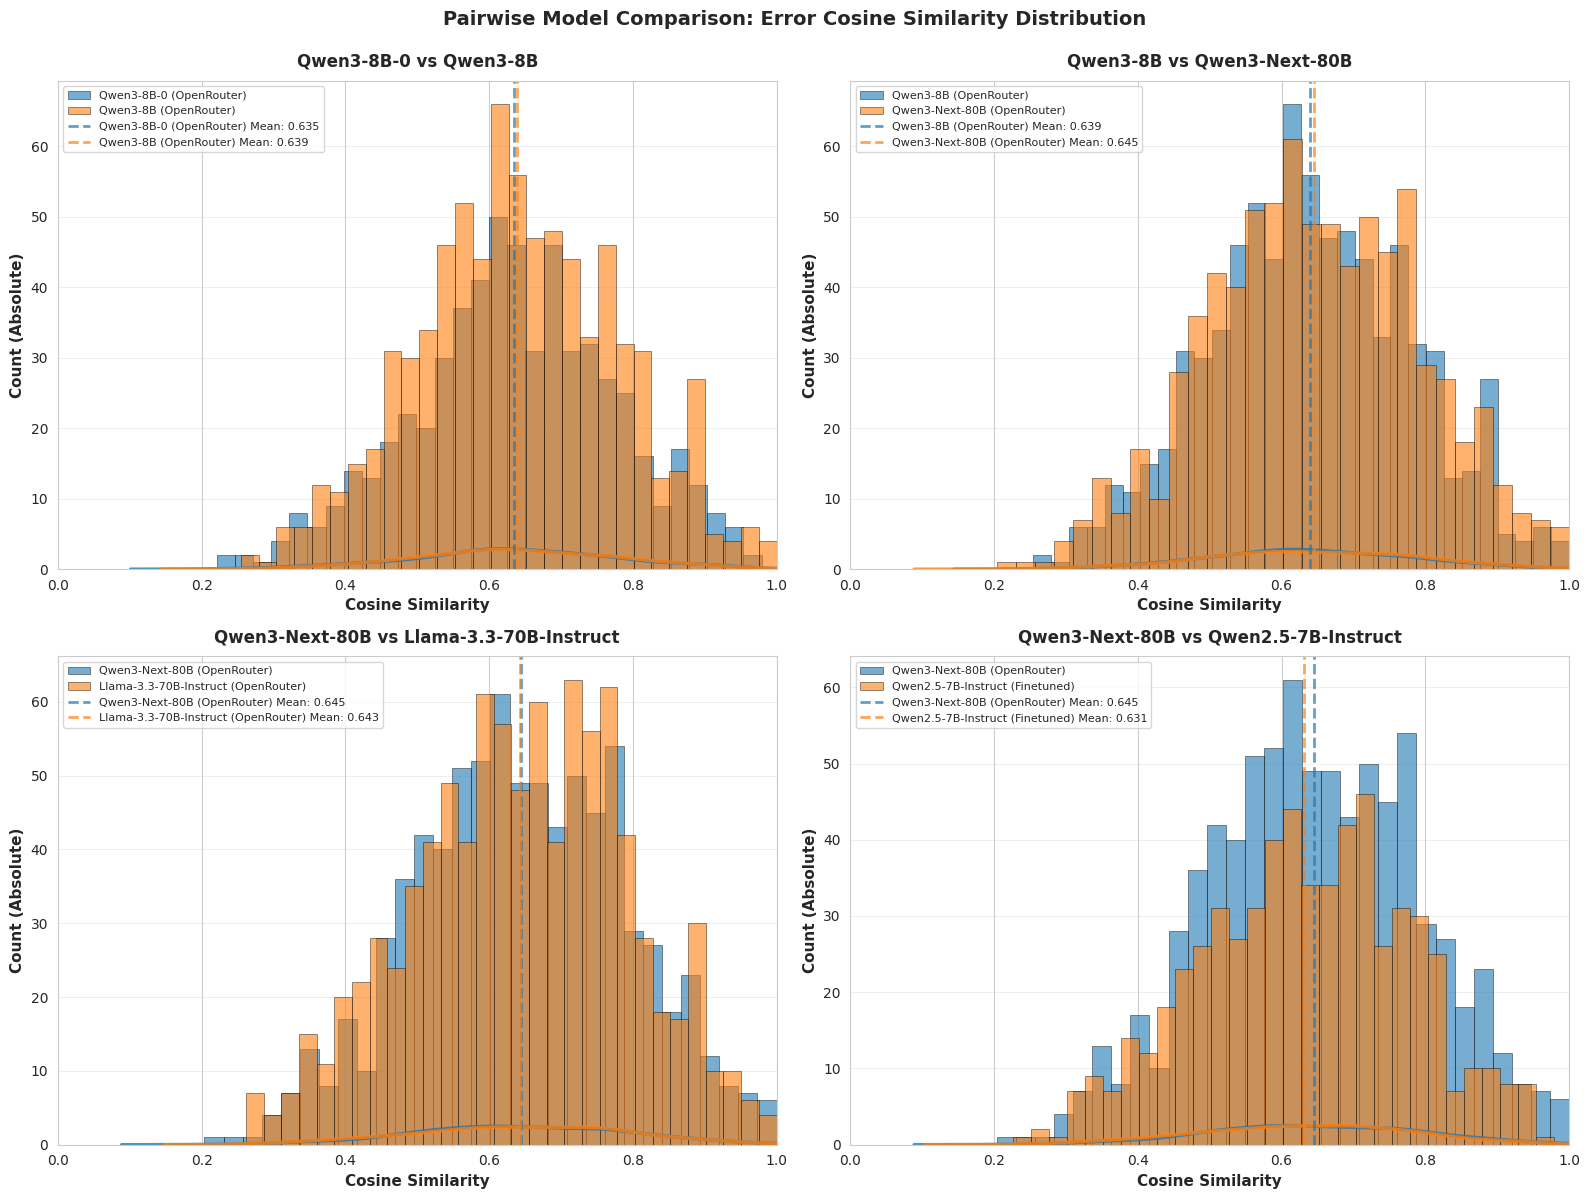

In [220]:
# Pairwise model comparison charts (using absolute counts, not density)
# Define model pairs for comparison
model_pairs = [
    ("Qwen3-8B-0 (OpenRouter)", "Qwen3-8B (OpenRouter)"),
    ("Qwen3-8B (OpenRouter)", "Qwen3-Next-80B (OpenRouter)"),
    ("Qwen3-Next-80B (OpenRouter)", "Llama-3.3-70B-Instruct (OpenRouter)"),
    ("Qwen3-Next-80B (OpenRouter)", "Qwen2.5-7B-Instruct (Finetuned)")
]

# Create subplots for each pair
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e']  # Blue and Orange

for idx, (model1, model2) in enumerate(model_pairs):
    ax = axes[idx]
    
    # Get data for both models
    data1 = combined_df_valid[combined_df_valid['model'] == model1]['cos_sim']
    data2 = combined_df_valid[combined_df_valid['model'] == model2]['cos_sim']
    
    # Plot histograms with absolute counts (density=False)
    ax.hist(data1, bins=30, alpha=0.6, label=model1, color=colors[0], edgecolor='black', linewidth=0.5)
    ax.hist(data2, bins=30, alpha=0.6, label=model2, color=colors[1], edgecolor='black', linewidth=0.5)
    
    # Add KDE curves
    sns.kdeplot(data=data1, ax=ax, color=colors[0], linewidth=2.5, alpha=0.8)
    sns.kdeplot(data=data2, ax=ax, color=colors[1], linewidth=2.5, alpha=0.8)
    
    # Add mean lines
    mean1 = data1.mean()
    mean2 = data2.mean()
    ax.axvline(mean1, color=colors[0], linestyle='--', linewidth=2, alpha=0.7, label=f'{model1} Mean: {mean1:.3f}')
    ax.axvline(mean2, color=colors[1], linestyle='--', linewidth=2, alpha=0.7, label=f'{model2} Mean: {mean2:.3f}')
    
    ax.set_xlabel('Cosine Similarity', fontsize=11, fontweight='bold')
    ax.set_ylabel('Count (Absolute)', fontsize=11, fontweight='bold')
    ax.set_title(f'{model1.split("(")[0].strip()} vs {model2.split("(")[0].strip()}', 
                fontsize=12, fontweight='bold', pad=10)
    ax.set_xlim([0, 1.0])
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=8, loc='upper left')

plt.suptitle('Pairwise Model Comparison: Error Cosine Similarity Distribution', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


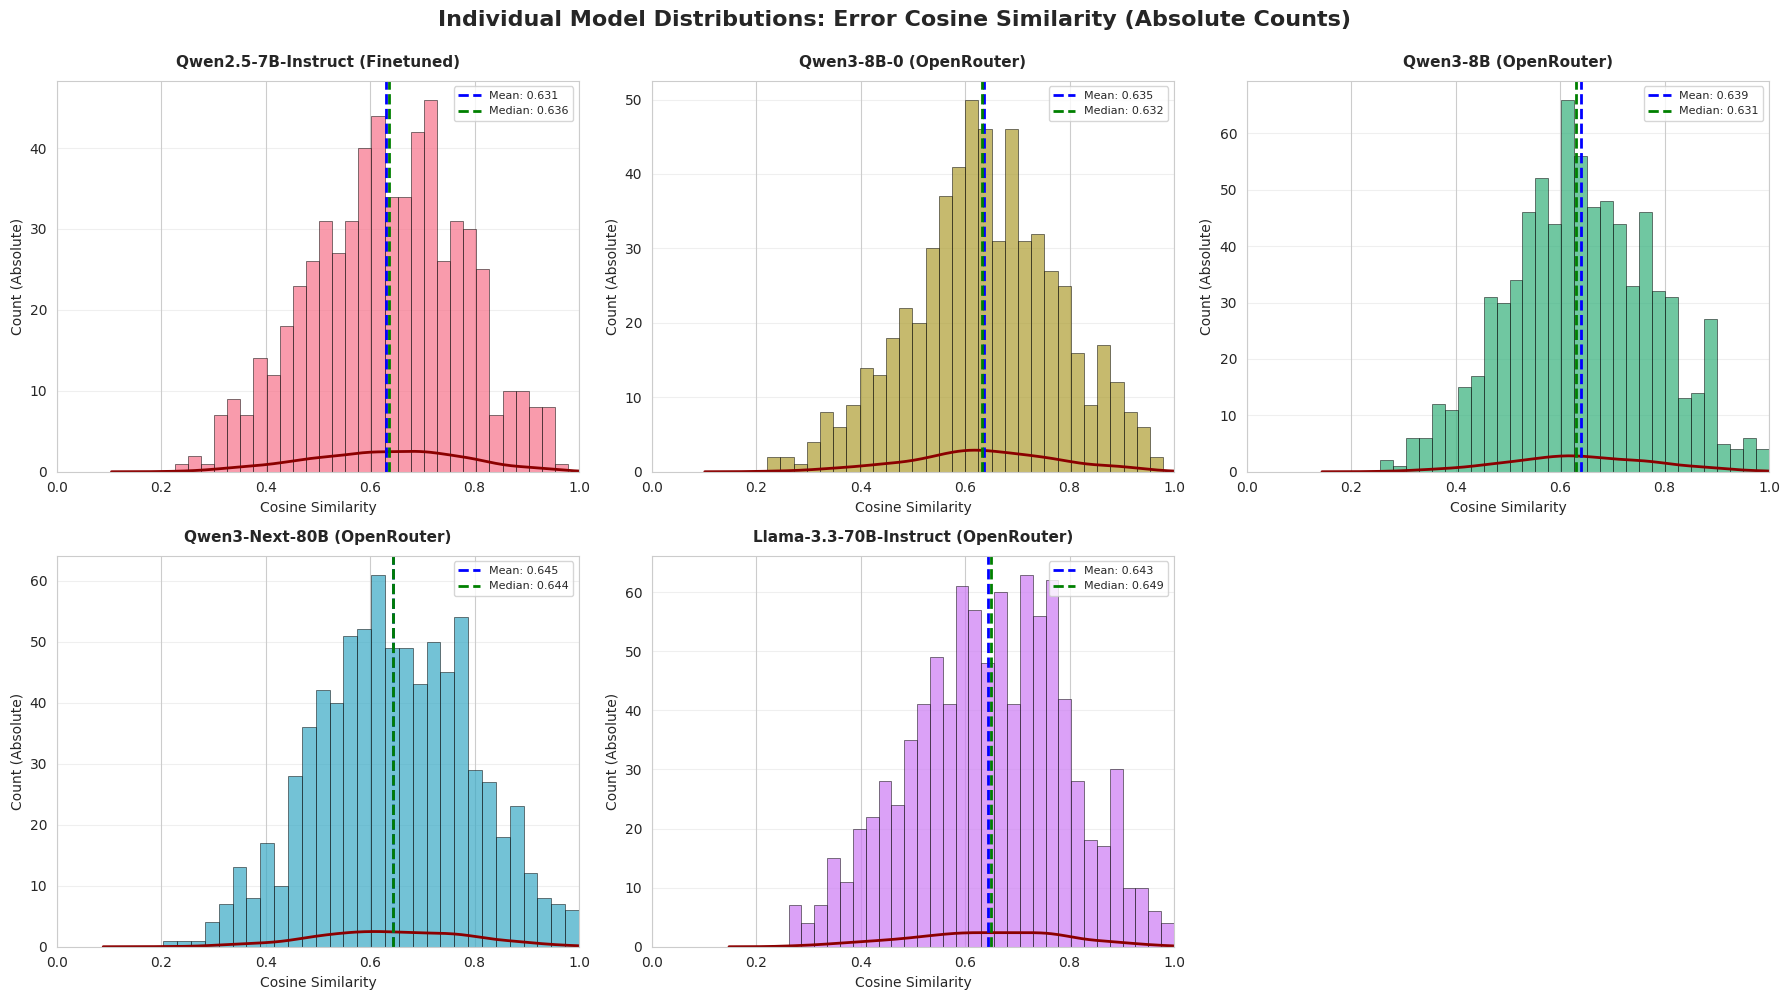

In [221]:
# Individual model distributions (for reference)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

models = combined_df_valid['model'].unique()
colors = sns.color_palette("husl", len(models))

for i, model in enumerate(models):
    if i < len(axes):
        model_data = combined_df_valid[combined_df_valid['model'] == model]['cos_sim']
        
        # Histogram with absolute counts
        axes[i].hist(model_data, bins=30, alpha=0.7, color=colors[i], edgecolor='black', linewidth=0.5)
        
        # KDE overlay
        sns.kdeplot(data=model_data, ax=axes[i], color='darkred', linewidth=2)
        
        # Add mean and median lines
        mean_val = model_data.mean()
        median_val = model_data.median()
        axes[i].axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
        axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')
        
        axes[i].set_title(model, fontsize=11, fontweight='bold', pad=10)
        axes[i].set_xlabel('Cosine Similarity', fontsize=10)
        axes[i].set_ylabel('Count (Absolute)', fontsize=10)
        axes[i].set_xlim([0, 1.0])
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].legend(fontsize=8, loc='upper right')

# Hide unused subplots
for i in range(len(models), len(axes)):
    axes[i].axis('off')

plt.suptitle('Individual Model Distributions: Error Cosine Similarity (Absolute Counts)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [222]:
# Summary statistics by model (using valid entries only)
summary_stats = combined_df_valid.groupby('model')['cos_sim'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).round(4)

print("Summary Statistics by Model:")
print("=" * 80)
print(summary_stats.to_string())

# Display as formatted table
display(summary_stats)


Summary Statistics by Model:
                                     count    mean  median     std     min     max     q25     q75
model                                                                                             
Llama-3.3-70B-Instruct (OpenRouter)    917  0.6435  0.6488  0.1488  0.2618  1.0000  0.5417  0.7531
Qwen2.5-7B-Instruct (Finetuned)        605  0.6309  0.6358  0.1455  0.2258  0.9792  0.5277  0.7301
Qwen3-8B (OpenRouter)                  783  0.6394  0.6310  0.1398  0.2545  1.0000  0.5447  0.7406
Qwen3-8B-0 (OpenRouter)                585  0.6352  0.6319  0.1424  0.2207  0.9792  0.5477  0.7340
Qwen3-Next-80B (OpenRouter)            792  0.6446  0.6442  0.1459  0.2039  1.0000  0.5447  0.7522


,count,mean,median,std,min,max,q25,q75
model,,,,,,,,
Llama-3.3-70B-Instruct (OpenRouter),917,0.6435,0.6488,0.1488,0.2618,1.0000,0.5417,0.7531
Qwen2.5-7B-Instruct (Finetuned),605,0.6309,0.6358,0.1455,0.2258,0.9792,0.5277,0.7301
Qwen3-8B (OpenRouter),783,0.6394,0.6310,0.1398,0.2545,1.0000,0.5447,0.7406
Qwen3-8B-0 (OpenRouter),585,0.6352,0.6319,0.1424,0.2207,0.9792,0.5477,0.7340
Qwen3-Next-80B (OpenRouter),792,0.6446,0.6442,0.1459,0.2039,1.0000,0.5447,0.7522


In [223]:
# Summary statistics by subject (using Qwen3-80B data only, valid entries only)
qwen3_80b_data = combined_df_valid[combined_df_valid['model'] == 'Qwen3-Next-80B (OpenRouter)']

subject_summary_stats = qwen3_80b_data.groupby('subject')['cos_sim'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).round(4)

# Reorder by subject order
subject_order = ['Science', 'Korean', 'Technology & Home Economics', 'Ethics', 'Social Studies', 
                 'Social & Cultural Studies', 'Mathematics', 'English', 'Information']
available_subjects = [s for s in subject_order if s in subject_summary_stats.index]
subject_summary_stats = subject_summary_stats.loc[available_subjects]

print("Summary Statistics by Subject (Qwen3-80B only):")
print("=" * 80)
print(subject_summary_stats.to_string())

# Display as formatted table
display(subject_summary_stats)


Summary Statistics by Subject (Qwen3-80B only):
                             count    mean  median     std     min     max     q25     q75
subject                                                                                   
Science                         58  0.6257  0.6496  0.1499  0.3199  0.9328  0.5125  0.7426
Korean                         114  0.5985  0.5827  0.1538  0.2825  0.9947  0.5006  0.7027
Technology & Home Economics    116  0.6268  0.6363  0.1493  0.2039  0.8973  0.5320  0.7330
Ethics                          83  0.6011  0.5942  0.1194  0.3246  0.8028  0.5157  0.6819
Social Studies                  70  0.6402  0.6395  0.1255  0.3948  0.8641  0.5409  0.7629
Social & Cultural Studies       64  0.6762  0.6750  0.1194  0.4726  0.8772  0.5897  0.7771
Mathematics                     65  0.6844  0.6884  0.1435  0.2395  1.0000  0.5860  0.7674
English                        135  0.6873  0.6801  0.1570  0.2856  0.9520  0.5729  0.8159
Information                     87  0.6673

,count,mean,median,std,min,max,q25,q75
subject,,,,,,,,
Science,58,0.6257,0.6496,0.1499,0.3199,0.9328,0.5125,0.7426
Korean,114,0.5985,0.5827,0.1538,0.2825,0.9947,0.5006,0.7027
Technology & Home Economics,116,0.6268,0.6363,0.1493,0.2039,0.8973,0.5320,0.7330
Ethics,83,0.6011,0.5942,0.1194,0.3246,0.8028,0.5157,0.6819
Social Studies,70,0.6402,0.6395,0.1255,0.3948,0.8641,0.5409,0.7629
Social & Cultural Studies,64,0.6762,0.6750,0.1194,0.4726,0.8772,0.5897,0.7771
Mathematics,65,0.6844,0.6884,0.1435,0.2395,1.0000,0.5860,0.7674
English,135,0.6873,0.6801,0.1570,0.2856,0.9520,0.5729,0.8159
Information,87,0.6673,0.6529,0.1380,0.3309,1.0000,0.5803,0.7532


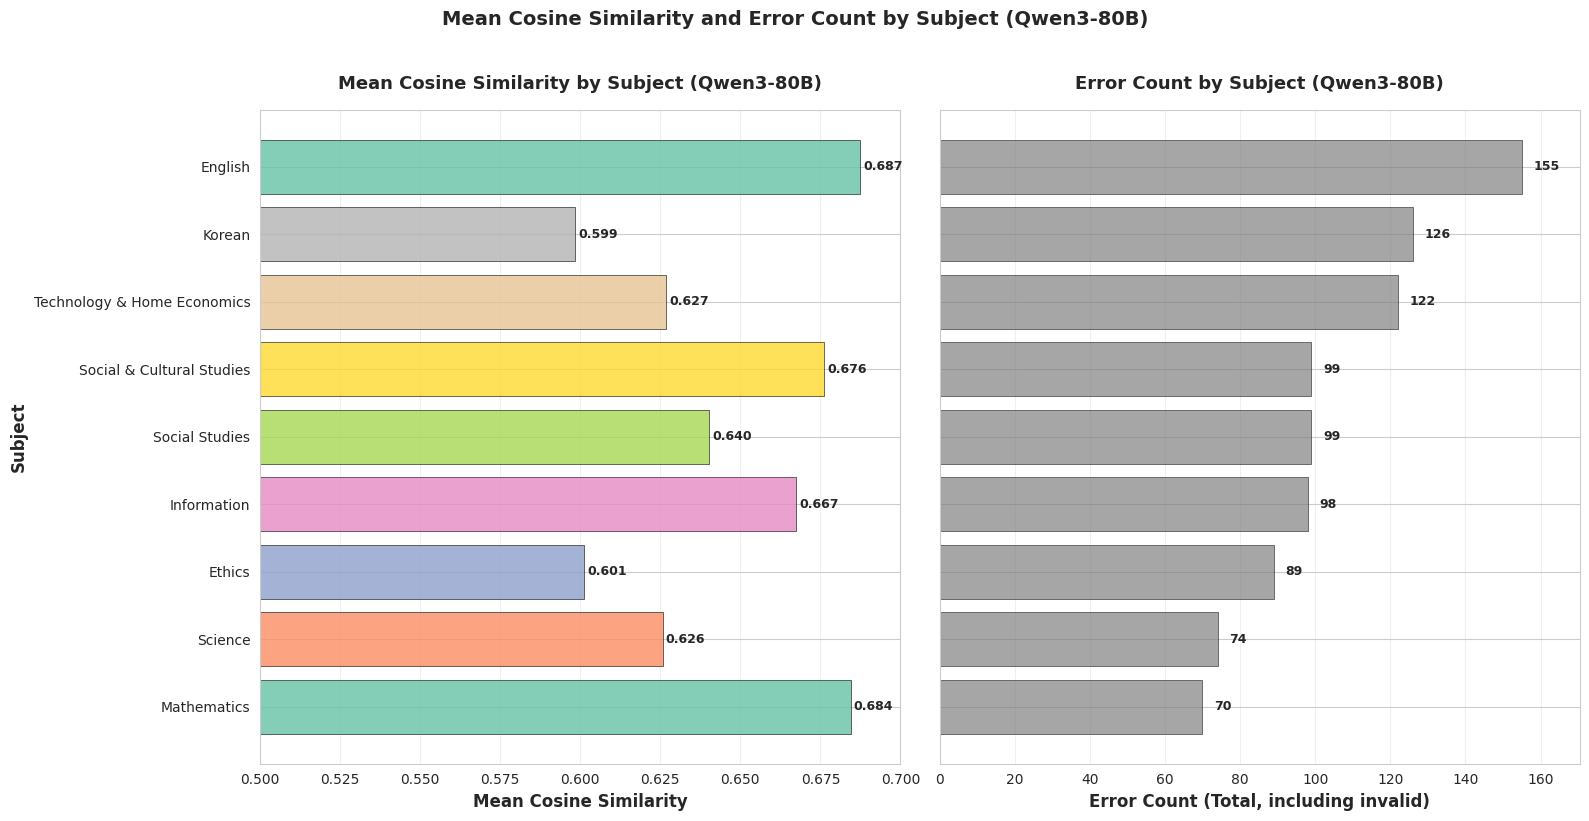

In [224]:
# Side-by-side bar charts of mean cosine similarity and error count by subject (Qwen3-80B only)
# Get data for Qwen3-80B (including invalid entries for error count)
qwen3_80b_all = combined_df[combined_df['model'] == 'Qwen3-Next-80B (OpenRouter)']

# Calculate mean (valid entries only) and total error count (all entries including invalid)
subject_means = subject_summary_stats['mean'].sort_values(ascending=True)
subject_error_counts = qwen3_80b_all.groupby('subject').size()

# Align subjects and sort error counts to match mean order
common_subjects = subject_means.index.intersection(subject_error_counts.index)
subject_means = subject_means.loc[common_subjects]
subject_error_counts = subject_error_counts.loc[common_subjects].sort_values(ascending=True)

# Ensure both are in the same order
subject_means = subject_means.loc[subject_error_counts.index]

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Left plot: Mean Cosine Similarity
y_pos = np.arange(len(subject_means))
bars1 = ax1.barh(y_pos, subject_means.values, 
                 color=sns.color_palette("Set2", len(subject_means)), 
                 alpha=0.8, edgecolor='black', linewidth=0.5)

# Add value labels for mean on the right of bars
for i, (subject, mean_val) in enumerate(subject_means.items()):
    ax1.text(mean_val + 0.001, i, f'{mean_val:.3f}', 
            ha='left', va='center', fontsize=9, fontweight='bold')

ax1.set_ylabel('Subject', fontsize=12, fontweight='bold')
ax1.set_xlabel('Mean Cosine Similarity', fontsize=12, fontweight='bold')
ax1.set_title('Mean Cosine Similarity by Subject (Qwen3-80B)', 
             fontsize=13, fontweight='bold', pad=15)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(subject_means.index)
ax1.set_xlim([0.5, 0.7])
ax1.grid(True, alpha=0.3, axis='x')

# Right plot: Error Count
bars2 = ax2.barh(y_pos, subject_error_counts.values,
                 color='gray', alpha=0.7, edgecolor='black', linewidth=0.5)

# Add value labels for error count on the right of bars
for i, (subject, count_val) in enumerate(subject_error_counts.items()):
    ax2.text(count_val + max(subject_error_counts.values) * 0.02, i, f'{int(count_val)}', 
            ha='left', va='center', fontsize=9, fontweight='bold')

ax2.set_xlabel('Error Count (Total, including invalid)', fontsize=12, fontweight='bold')
ax2.set_title('Error Count by Subject (Qwen3-80B)', 
             fontsize=13, fontweight='bold', pad=15)
ax2.set_xlim([0, max(subject_error_counts.values) * 1.1])
ax2.grid(True, alpha=0.3, axis='x')

plt.suptitle('Mean Cosine Similarity and Error Count by Subject (Qwen3-80B)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


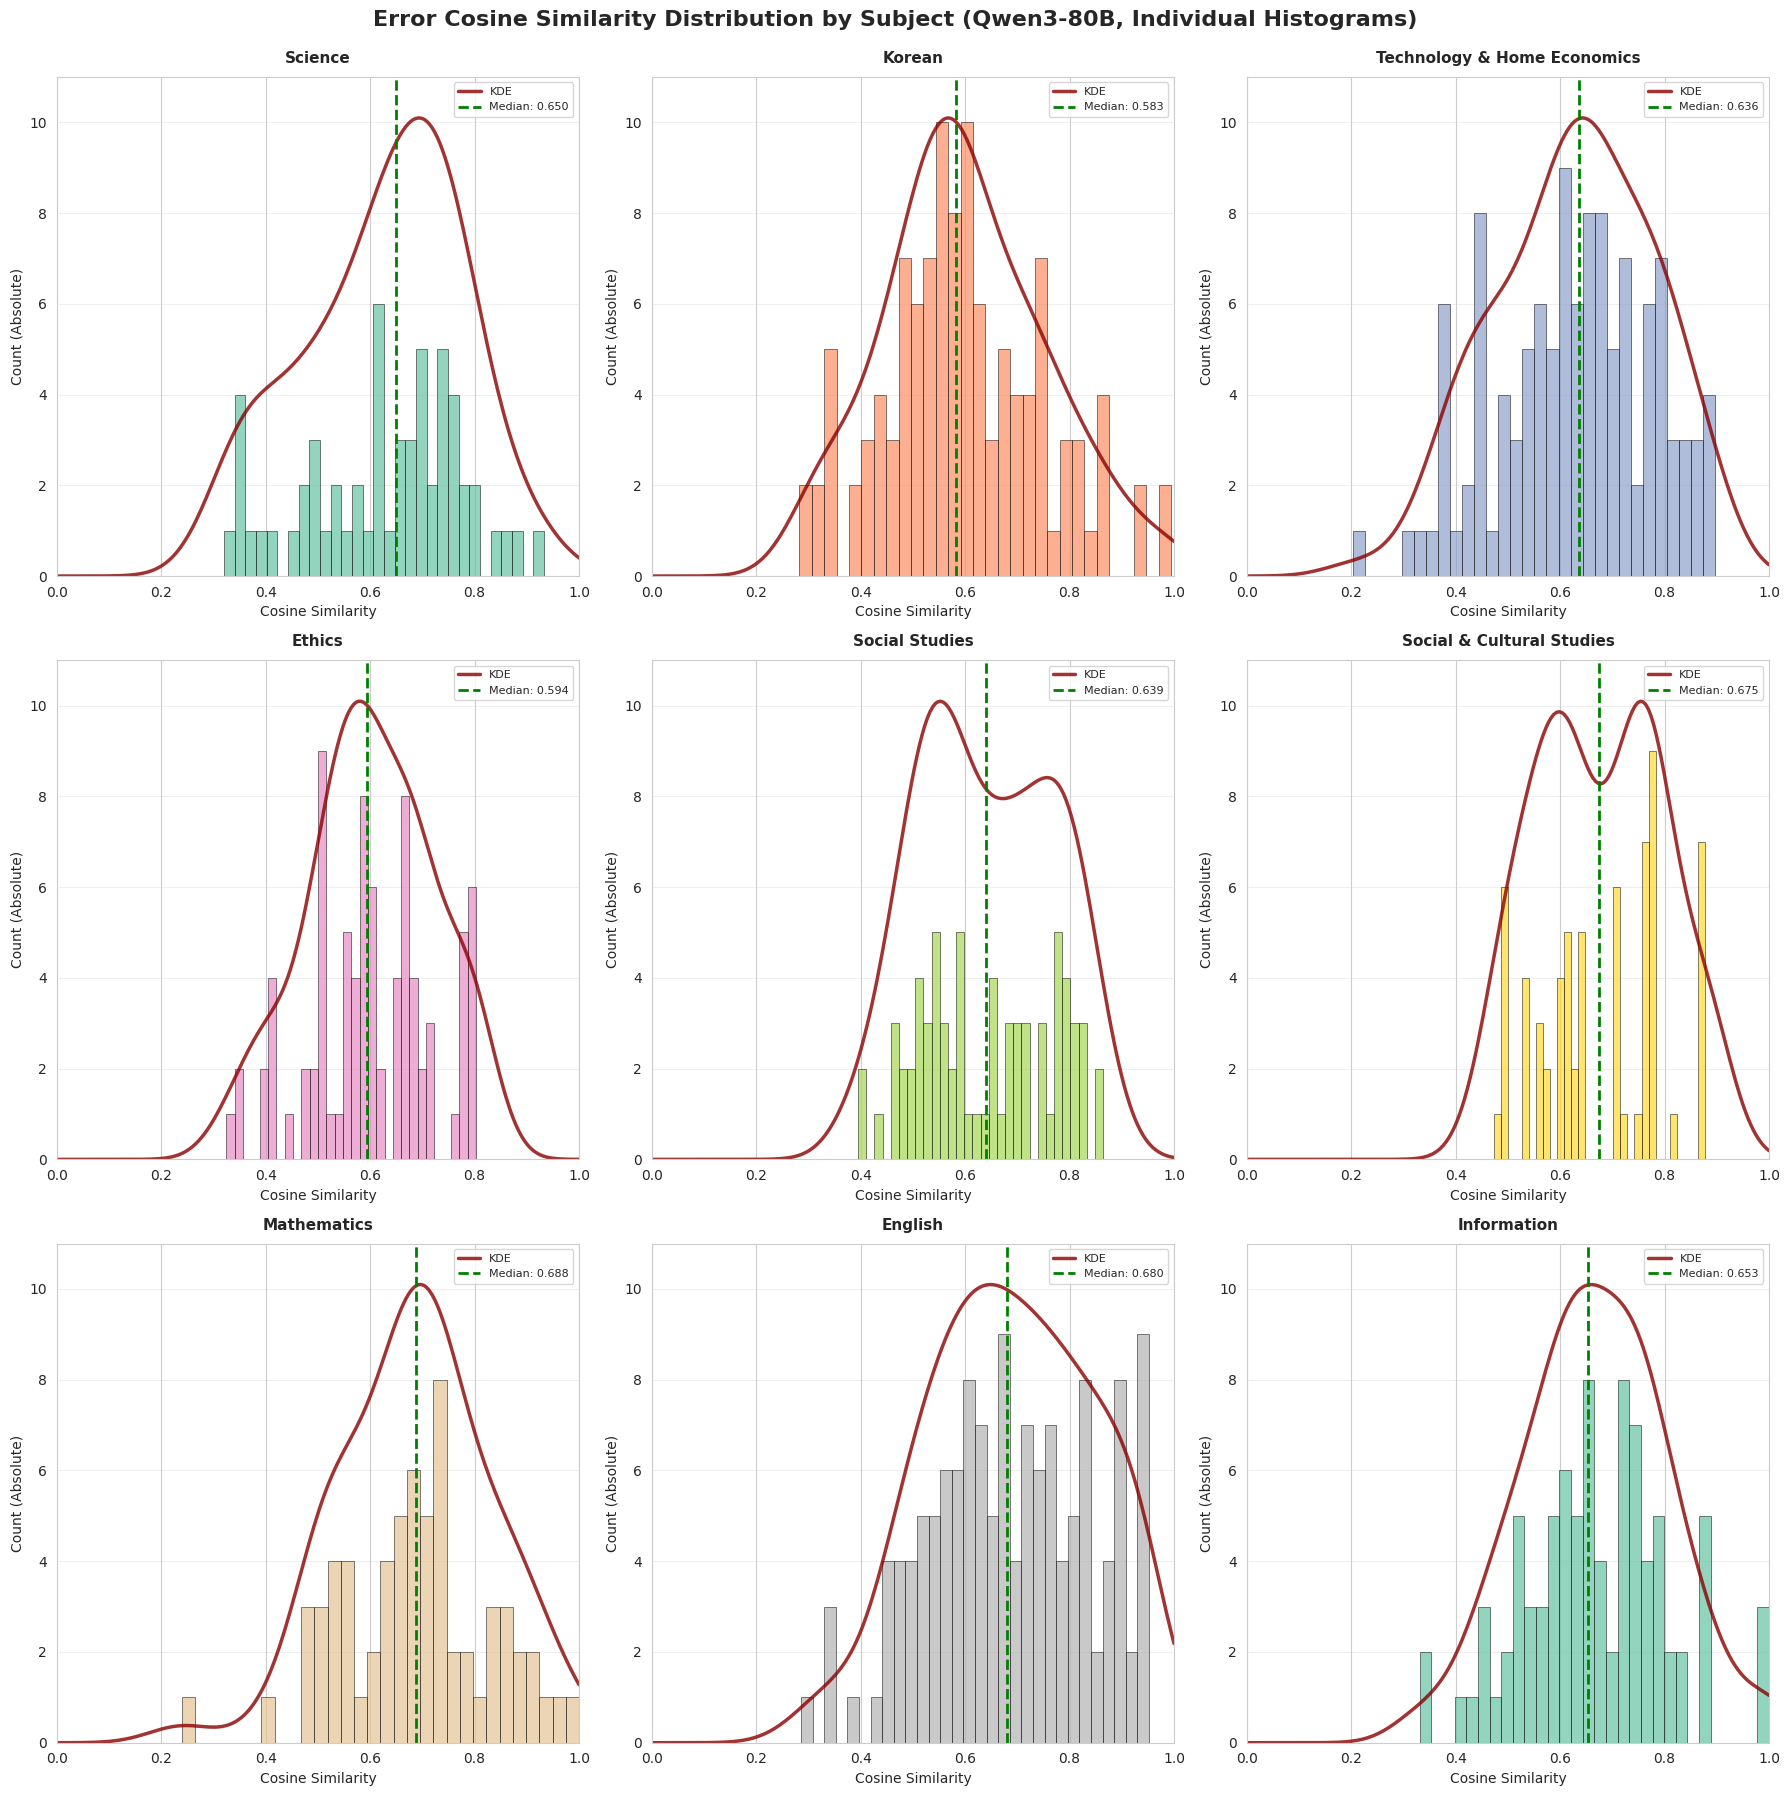

In [225]:
# Individual subject distributions (faceted histogram with KDE) - Qwen3-80B only
# Subject order (English names)
qwen3_80b_data = combined_df_valid[combined_df_valid['model'] == 'Qwen3-Next-80B (OpenRouter)']
subject_order = ['Science', 'Korean', 'Technology & Home Economics', 'Ethics', 'Social Studies', 
                 'Social & Cultural Studies', 'Mathematics', 'English', 'Information']
available_subjects = [s for s in subject_order if s in qwen3_80b_data['subject'].unique()]

# Create subplots (3x3 grid for 9 subjects)
n_subjects = len(available_subjects)
n_cols = 3
n_rows = (n_subjects + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten() if n_subjects > 1 else [axes]

# Get colors for each subject
colors = sns.color_palette("Set2", len(available_subjects))

# First pass: calculate maximum count and maximum KDE value across all subjects
from scipy import stats
max_count = 0
max_kde_value = 0
kde_objects = []

for subject in available_subjects:
    subject_data = qwen3_80b_data[qwen3_80b_data['subject'] == subject]['cos_sim']
    counts, _ = np.histogram(subject_data, bins=30)
    max_count = max(max_count, counts.max())
    
    # Calculate KDE for max value
    kde = stats.gaussian_kde(subject_data)
    x_kde = np.linspace(0, 1.0, 200)
    y_kde = kde(x_kde)
    bin_width = (1.0 - 0.0) / 30
    y_kde_scaled = y_kde * len(subject_data) * bin_width
    max_kde_value = max(max_kde_value, y_kde_scaled.max())
    kde_objects.append(kde)

# Add some padding (10% above max)
max_y = max_count * 1.1

# Second pass: plot histograms and KDE
for i, subject in enumerate(available_subjects):
    ax = axes[i]
    subject_data = qwen3_80b_data[qwen3_80b_data['subject'] == subject]['cos_sim']
    
    # Histogram with absolute counts
    counts, bins, patches = ax.hist(subject_data, bins=30, alpha=0.7, color=colors[i], edgecolor='black', linewidth=0.5)
    
    # Calculate KDE and scale it to uniform maximum
    kde = kde_objects[i]
    x_kde = np.linspace(0, 1.0, 200)
    y_kde = kde(x_kde)
    
    # Scale KDE to match histogram: multiply by number of data points and bin width
    bin_width = bins[1] - bins[0]
    y_kde_scaled = y_kde * len(subject_data) * bin_width
    
    # Scale to uniform maximum KDE value
    scale_factor = max_kde_value / y_kde_scaled.max() if y_kde_scaled.max() > 0 else 1
    y_kde_scaled = y_kde_scaled * scale_factor
    
    # Plot scaled KDE
    ax.plot(x_kde, y_kde_scaled, color='darkred', linewidth=2.5, alpha=0.8, label='KDE')
    
    # Add median line only
    median_val = subject_data.median()
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')
    
    ax.set_title(subject, fontsize=11, fontweight='bold', pad=10)
    ax.set_xlabel('Cosine Similarity', fontsize=10)
    ax.set_ylabel('Count (Absolute)', fontsize=10)
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, max_y])  # Set uniform y-axis limit
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=8, loc='upper right')

# Hide unused subplots
for i in range(len(available_subjects), len(axes)):
    axes[i].axis('off')

plt.suptitle('Error Cosine Similarity Distribution by Subject (Qwen3-80B, Individual Histograms)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


Total invalid entries (cos_sim == -1): 1567
Invalid entries by model:
model
Llama-3.3-70B-Instruct (OpenRouter)     70
Qwen2.5-7B-Instruct (Finetuned)        184
Qwen3-8B (OpenRouter)                  466
Qwen3-8B-0 (OpenRouter)                707
Qwen3-Next-80B (OpenRouter)            140
dtype: int64

Error counts by range:
                                  model cos_sim_range  error_count
0   Llama-3.3-70B-Instruct (OpenRouter)       0.0-0.6          345
1   Llama-3.3-70B-Instruct (OpenRouter)       0.6-0.8          444
2   Llama-3.3-70B-Instruct (OpenRouter)       0.8-1.0          128
3   Llama-3.3-70B-Instruct (OpenRouter)       Invalid           70
4       Qwen2.5-7B-Instruct (Finetuned)       0.0-0.6          245
5       Qwen2.5-7B-Instruct (Finetuned)       0.6-0.8          285
6       Qwen2.5-7B-Instruct (Finetuned)       0.8-1.0           75
7       Qwen2.5-7B-Instruct (Finetuned)       Invalid          184
8                 Qwen3-8B (OpenRouter)       0.0-0.6          302
9 

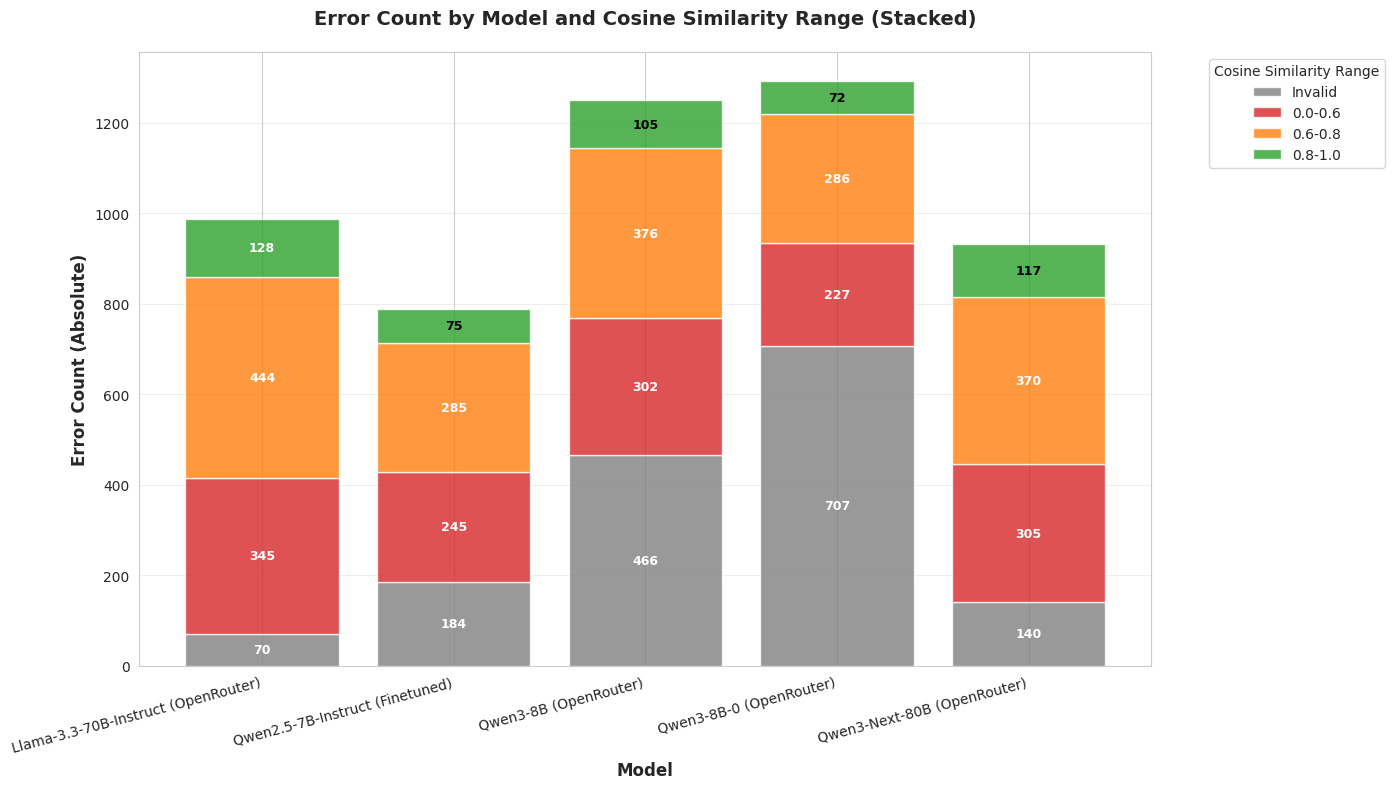


Error Count Summary by Model and Cosine Similarity Range:
cos_sim_range                        Invalid  0.0-0.6  0.6-0.8  0.8-1.0
model                                                                  
Llama-3.3-70B-Instruct (OpenRouter)     70.0    345.0    444.0    128.0
Qwen2.5-7B-Instruct (Finetuned)        184.0    245.0    285.0     75.0
Qwen3-8B (OpenRouter)                  466.0    302.0    376.0    105.0
Qwen3-8B-0 (OpenRouter)                707.0    227.0    286.0     72.0
Qwen3-Next-80B (OpenRouter)            140.0    305.0    370.0    117.0


In [226]:
# Stacked bar chart: Error count by Model and Cosine Similarity Range (absolute values)
# Define cosine similarity ranges (including invalid)
def categorize_cos_sim(cos_sim):
    if cos_sim == -1:
        return 'Invalid'
    elif 0.0 <= cos_sim < 0.6:
        return '0.0-0.6'
    elif 0.6 <= cos_sim < 0.8:
        return '0.6-0.8'
    elif 0.8 <= cos_sim <= 1.0:
        return '0.8-1.0'
    else:
        return 'Other'

# Add cos_sim_range column
combined_df['cos_sim_range'] = combined_df['cos_sim'].apply(categorize_cos_sim)

# Debug: Check for invalid entries
invalid_entries = combined_df[combined_df['cos_sim'] == -1]
print(f"Total invalid entries (cos_sim == -1): {len(invalid_entries)}")
if len(invalid_entries) > 0:
    print(f"Invalid entries by model:")
    print(invalid_entries.groupby('model').size())

# Count errors by model and cos_sim range
error_counts = combined_df.groupby(['model', 'cos_sim_range']).size().reset_index(name='error_count')
print(f"\nError counts by range:")
print(error_counts)

# Define range order (Invalid first, then valid ranges)
range_order = ['Invalid', '0.0-0.6', '0.6-0.8', '0.8-1.0']

# Create pivot table for stacked bar chart
pivot_counts = error_counts.pivot_table(
    values='error_count',
    index='model',
    columns='cos_sim_range',
    fill_value=0
)

# Ensure all ranges are included (add missing columns with 0 values)
for range_name in range_order:
    if range_name not in pivot_counts.columns:
        pivot_counts[range_name] = 0

# Reorder columns to match range_order
pivot_counts = pivot_counts[range_order]

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Get colors for each range (gray for invalid, red for low, orange for medium, green for high)
colors = ['#808080', '#d62728', '#ff7f0e', '#2ca02c']  # Gray, Red, Orange, Green

# Plot stacked bars
bottom = np.zeros(len(pivot_counts.index))
bars = []

for i, cos_range in enumerate(range_order):
    if cos_range in pivot_counts.columns:
        values = pivot_counts[cos_range].values
        # Always plot the bar, even if values are 0 (for legend visibility)
        bar = ax.bar(
            range(len(pivot_counts.index)),
            values,
            bottom=bottom,
            label=cos_range,
            color=colors[i],
            alpha=0.8
        )
        bars.append(bar)
        
        # Add value labels on each segment (only if value > 0)
        for j, val in enumerate(values):
            if val > 0:  # Only label if value is greater than 0
                text_color = 'white' if val > max(bottom) * 0.1 else 'black'  # Use black text if bar is too small
                ax.text(j, bottom[j] + val/2, str(int(val)),
                       ha='center', va='center', fontsize=9, fontweight='bold', color=text_color)
        
        # Update bottom for next iteration
        bottom += values

# Customize plot
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Error Count (Absolute)', fontsize=12, fontweight='bold')
ax.set_title('Error Count by Model and Cosine Similarity Range (Stacked)', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(len(pivot_counts.index)))
ax.set_xticklabels(pivot_counts.index, rotation=15, ha='right')
ax.legend(title='Cosine Similarity Range', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary table
print("\nError Count Summary by Model and Cosine Similarity Range:")
print("=" * 80)
print(pivot_counts.to_string())
